<a href="https://colab.research.google.com/github/IC-04/ST-Radar/blob/main/STRadar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector
from keras import backend as K
import io
import zipfile
from google.colab import files
from tqdm import tqdm
import seaborn as sns
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import os
import glob
for file in glob.glob('/content/*'):
  try:
    os.remove(file)
    print(f"Deleted: {file}")
  except:
    print(f"Could not delete: {file}")


Could not delete: /content/sample_data


Add that disturbance for less than a certain time not to be flagged as a warning cause aeroplane disturbance,random noise can be detected as a sudden weather change


In [3]:
from google.colab import drive, files
import pandas as pd
import io
import re
import os
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/ST_Radar_Lower'
os.makedirs(drive_path, exist_ok=True)
csv_path = f'{drive_path}/parsed_df.csv'

wind_cols = ["Ht(m)", "Ht(ft)", "U(ms)", "U(kt)", "V(ms)", "V(kt)","W(ms)", "W(kt)", "WS(ms)", "WS(kt)", "WD(ms)"]
signal_cols = ["Ht(m)", "Ht(ft)", "M0(dB)", "M1(Hz)", "RV(m/s)","DW(Hz)", "NL(dB)", "SNR(dB)", "Cn2(dB)"]

if os.path.exists(csv_path):
    parsed_df = pd.read_csv(csv_path)
    print(f"Loaded existing parsed_df with {len(parsed_df)} rows.")
else:
    parsed_df = pd.DataFrame()
    print("No existing parsed_df found. Starting fresh...")

while True:
    more = input("Do you want to upload another day? (y/n): ").strip().lower()
    if more != 'y':
        break
    print("\n Upload wind and signal files for ONE DAY...")
    uploaded = files.upload()

    try:
        day = int(input("Enter the day (e.g., 1): "))
        month = int(input("Enter the month (e.g., 5 for May): "))
        year = int(input("Enter the year (e.g., 2023): "))
    except:
        print(" Invalid date input. Skipping this batch.")
        continue

    filenames = sorted(uploaded.keys())
    base_files = [f for f in filenames if " (2)" not in f]

    rows_before = len(parsed_df)

    for wind_file in base_files:
        signal_file = wind_file + " (2)"
        if signal_file not in uploaded:
            print(f" Skipping {wind_file} — missing signal file.")
            continue

        try:
            df_wind = pd.read_csv(io.StringIO(uploaded[wind_file].decode('utf-8')), sep=r'\s+', header=None)
            df_signal = pd.read_csv(io.StringIO(uploaded[signal_file].decode('utf-8')), sep=r'\s+', header=None)
        except Exception as e:
            print(f" Error reading files: {e}")
            continue

        if df_wind.shape[1] != 11 or df_signal.shape[1] != 9:
            print(f" Skipping {wind_file} — expected 11 columns, found {df_wind.shape[1]} Skipping {signal_file} — expected 9 columns, found {df_moment.shape[1]}")
            continue

        df_wind.columns = wind_cols
        df_signal.columns = signal_cols

        df_wind = df_wind.drop(columns=["Ht(ft)"])
        df_signal = df_signal.drop(columns=["Ht(ft)"])
        df_wind["Ht(m)"] = pd.to_numeric(df_wind["Ht(m)"], errors="coerce").round(2)
        df_signal["Ht(m)"] = pd.to_numeric(df_signal["Ht(m)"], errors="coerce").round(2)

        df_wind = df_wind.dropna(subset=["Ht(m)"])
        df_signal = df_signal.dropna(subset=["Ht(m)"])

        df_merged = pd.merge(df_wind, df_signal, on="Ht(m)", how="inner")

        if df_merged.empty:
          print(f" Merge failed for: {wind_file} and {signal_file}")
          continue

        time_match = re.search(r'Time(\d+)', wind_file)
        timestamp = time_match.group(1) if time_match else "Unknown"

        df_merged["Timestamp"] = timestamp
        df_merged["Day"] = day
        df_merged["Month"] = month
        df_merged["Year"] = year

        parsed_df = pd.concat([parsed_df, df_merged], ignore_index=True)

    print(f"Added {len(parsed_df) - rows_before} new rows for {day}/{month}/{year}.")


parsed_df['Timestamp'] = pd.to_numeric(parsed_df['Timestamp'], errors='coerce')
parsed_df = parsed_df.sort_values(by=["Year", "Month", "Day", "Timestamp"]).reset_index(drop=True)
parsed_df.to_csv(csv_path, index=False)
print(f"\nFinal saved parsed_df with {len(parsed_df)} rows to {csv_path}")

Mounted at /content/drive
Loaded existing parsed_df with 16650 rows.
Do you want to upload another day? (y/n): n

Final saved parsed_df with 16650 rows to /content/drive/MyDrive/ST_Radar_Lower/parsed_df.csv


In [4]:
#parsed_df.shape
#parsed_df['Timestamp'].nunique()
#parsed_df.groupby('Timestamp').size().head()  # rows per time
#parsed_df.describe()
#parsed_df.isna().sum()  # check for missing values


In [5]:
list(uploaded.keys())[:10]  # Preview first few uploaded file names

NameError: name 'uploaded' is not defined

In [6]:
parsed_df.tail(200)


,Ht(m),U(ms),U(kt),V(ms),V(kt),W(ms),W(kt),WS(ms),WS(kt),WD(ms),...,M1(Hz),RV(m/s),DW(Hz),NL(dB),SNR(dB),Cn2(dB),Timestamp,Day,Month,Year
16450,16650,1049.86,2040.0,283.44,550.96,6.42,12.00,1087.45,2113.0,254.89,...,7.76,-21.97,0.23,94.05,-15.55,-18.16,142844,28,5,2025
16451,16800,17.07,33.0,-25.97,-50.00,-31.53,-61.29,31.07,60.0,326.68,...,15.03,-42.55,0.23,94.10,-15.54,-18.15,142844,28,5,2025
16452,16950,1201.05,2334.0,344.88,670.39,-3.53,-6.86,1249.58,2428.0,253.98,...,8.93,-25.28,0.23,93.83,-16.96,-18.29,142844,28,5,2025
16453,17100,123.54,240.0,-32.92,-63.00,-26.38,-51.29,127.85,248.0,284.92,...,18.31,-51.82,0.28,94.36,-15.48,-18.13,142844,28,5,2025
16454,17250,-185.98,-361.0,-83.39,-162.00,-11.75,-22.83,203.82,396.0,65.85,...,12.25,-34.68,0.34,94.37,-15.01,-18.08,142844,28,5,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16645,23400,381.94,742.0,103.87,201.90,32.91,63.00,395.81,769.0,254.79,...,1.12,-3.18,0.23,94.34,-16.71,-17.98,142940,28,5,2025
16646,23550,248.05,482.0,12.80,24.88,-8.12,-15.79,248.38,482.0,267.05,...,13.10,-37.09,0.28,93.69,-13.42,-17.65,142940,28,5,2025
16647,23700,-0.00,-0.0,-0.00,-0.00,-41.91,-81.48,0.00,0.0,77.54,...,14.63,-41.41,0.28,93.78,-3.42,-16.64,142940,28,5,2025
16648,23850,-0.00,-0.0,-0.00,-0.00,-41.91,-81.48,0.00,0.0,77.94,...,14.63,-41.41,0.28,94.06,-4.97,-16.79,142940,28,5,2025


In [7]:
parsed_df.describe()

,Ht(m),U(ms),U(kt),V(ms),V(kt),W(ms),W(kt),WS(ms),WS(kt),WD(ms),...,M1(Hz),RV(m/s),DW(Hz),NL(dB),SNR(dB),Cn2(dB),Timestamp,Day,Month,Year
count,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,...,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000
mean,12825.000000,5.895541,11.503063,4.266333,8.493508,-0.313252,-0.849937,130.054511,252.301141,164.479625,...,0.212820,-0.602644,0.329398,105.897405,-5.303601,-17.388941,129491.972973,13.234234,5.783784,2023.315315
std,6495.241244,212.714217,413.198424,74.879329,145.413410,8.826691,17.022260,184.369257,358.391592,89.545996,...,6.794985,19.231147,0.248393,6.624971,15.317007,1.171274,46361.682260,9.753975,3.454844,1.030923
min,1650.000000,-1282.540000,-2493.000000,-358.050000,-695.000000,-48.920000,-95.090000,0.000000,0.000000,0.000000,...,-22.880000,-64.390000,0.080000,92.950000,-24.330000,-20.640000,42310.000000,1.000000,1.000000,2022.000000
25%,7200.000000,-31.580000,-61.000000,-4.730000,-9.000000,-1.040000,-2.010000,22.930000,44.000000,80.820000,...,-0.400000,-2.500000,0.230000,102.862500,-16.720000,-18.230000,95247.000000,5.000000,5.000000,2023.000000
50%,12825.000000,-5.095000,-9.000000,3.980000,7.740000,0.100000,0.000000,52.725000,102.000000,128.125000,...,0.060000,-0.180000,0.280000,105.955000,-10.650000,-17.680000,142310.000000,16.000000,5.000000,2023.000000
75%,18450.000000,60.675000,117.000000,21.890000,42.540000,0.610000,1.000000,146.177500,284.000000,251.970000,...,0.890000,1.120000,0.370000,108.930000,3.087500,-16.750000,170847.000000,18.000000,5.000000,2024.000000
max,24000.000000,1311.160000,2548.000000,361.240000,702.200000,54.260000,105.000000,1352.920000,2629.000000,360.000000,...,22.750000,64.750000,8.970000,154.060000,45.040000,-12.860000,183043.000000,28.000000,12.000000,2025.000000


In [8]:
parsed_df.head(155)

,Ht(m),U(ms),U(kt),V(ms),V(kt),W(ms),W(kt),WS(ms),WS(kt),WD(ms),...,M1(Hz),RV(m/s),DW(Hz),NL(dB),SNR(dB),Cn2(dB),Timestamp,Day,Month,Year
0,1650,1.25,2.0,-3.23,-6.0,0.15,0.0,3.47,6.0,338.85,...,-0.21,0.60,0.23,125.07,39.87,-14.46,42310,18,12,2022
1,1800,1.00,1.0,-3.23,-6.0,0.12,0.0,3.38,6.0,342.84,...,-0.21,0.60,0.23,119.04,36.67,-14.71,42310,18,12,2022
2,1950,-0.50,-0.0,-2.49,-4.0,0.15,0.0,2.54,4.0,11.30,...,-0.21,0.60,0.23,118.99,35.53,-14.75,42310,18,12,2022
3,2100,1.50,2.0,-3.23,-6.0,0.14,0.0,3.56,6.0,335.10,...,-0.21,0.60,0.23,116.43,35.88,-14.65,42310,18,12,2022
4,2250,1.49,2.0,-0.25,-0.0,0.01,0.0,1.51,2.0,279.46,...,-0.06,0.17,0.20,115.57,26.35,-15.54,42310,18,12,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,1650,2.00,3.0,-3.98,-7.0,0.07,0.0,4.45,8.0,333.38,...,-0.27,0.78,0.23,127.81,42.76,-14.17,42838,18,12,2022
151,1800,1.25,2.0,-3.98,-7.0,0.14,0.0,4.17,8.0,342.55,...,-0.27,0.78,0.23,122.11,39.77,-14.40,42838,18,12,2022
152,1950,1.50,2.0,-3.24,-6.0,0.10,0.0,3.57,6.0,335.16,...,-0.21,0.60,0.23,119.21,36.87,-14.62,42838,18,12,2022
153,2100,1.00,1.0,-3.73,-7.0,0.12,0.0,3.86,7.0,345.02,...,-0.24,0.69,0.26,116.51,40.29,-14.21,42838,18,12,2022


In [9]:
parsed_df.head()

,Ht(m),U(ms),U(kt),V(ms),V(kt),W(ms),W(kt),WS(ms),WS(kt),WD(ms),...,M1(Hz),RV(m/s),DW(Hz),NL(dB),SNR(dB),Cn2(dB),Timestamp,Day,Month,Year
0,1650,1.25,2.0,-3.23,-6.0,0.15,0.0,3.47,6.0,338.85,...,-0.21,0.60,0.23,125.07,39.87,-14.46,42310,18,12,2022
1,1800,1.00,1.0,-3.23,-6.0,0.12,0.0,3.38,6.0,342.84,...,-0.21,0.60,0.23,119.04,36.67,-14.71,42310,18,12,2022
2,1950,-0.50,-0.0,-2.49,-4.0,0.15,0.0,2.54,4.0,11.30,...,-0.21,0.60,0.23,118.99,35.53,-14.75,42310,18,12,2022
3,2100,1.50,2.0,-3.23,-6.0,0.14,0.0,3.56,6.0,335.10,...,-0.21,0.60,0.23,116.43,35.88,-14.65,42310,18,12,2022
4,2250,1.49,2.0,-0.25,-0.0,0.01,0.0,1.51,2.0,279.46,...,-0.06,0.17,0.20,115.57,26.35,-15.54,42310,18,12,2022


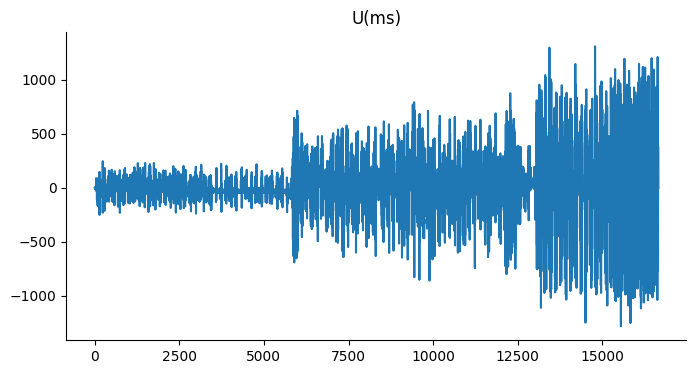

In [10]:
# @title U(ms)

from matplotlib import pyplot as plt
parsed_df['U(ms)'].plot(kind='line', figsize=(8, 4), title='U(ms)')
plt.gca().spines[['top', 'right']].set_visible(False)

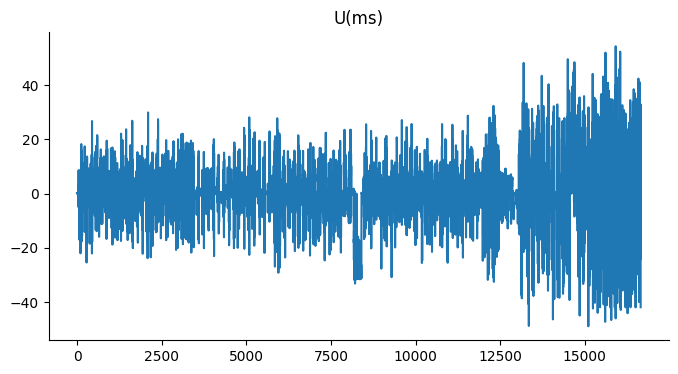

In [11]:
# @title U(ms)

from matplotlib import pyplot as plt
parsed_df['W(ms)'].plot(kind='line', figsize=(8, 4), title='U(ms)')
plt.gca().spines[['top', 'right']].set_visible(False)

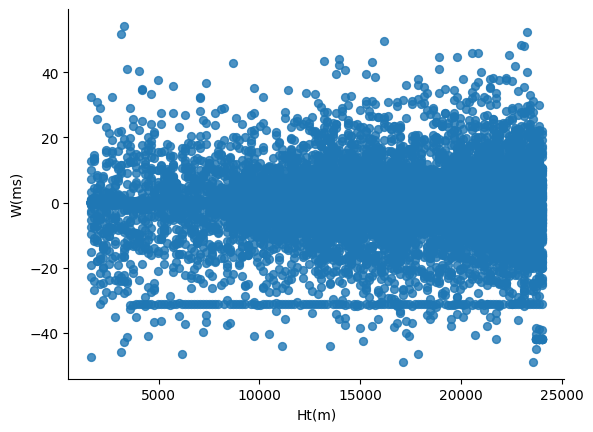

In [12]:
# @title Ht(m) vs W(ms)

from matplotlib import pyplot as plt
parsed_df.plot(kind='scatter', x='Ht(m)', y='W(ms)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

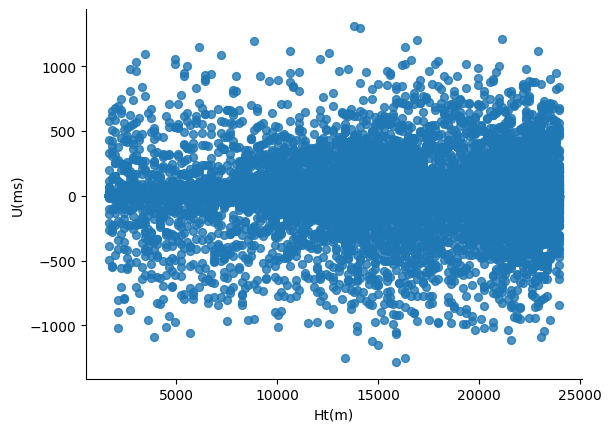

In [13]:
# @title Ht(m) vs U(ms)

from matplotlib import pyplot as plt
parsed_df.plot(kind='scatter', x='Ht(m)', y='U(ms)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

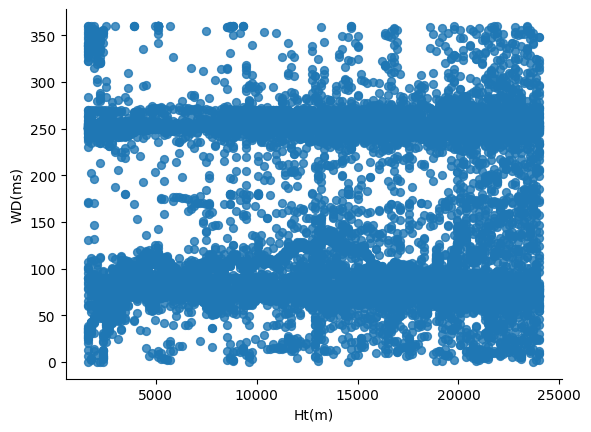

In [14]:
from matplotlib import pyplot as plt
parsed_df.plot(kind='scatter', x='Ht(m)', y='WD(ms)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Kalbaisakhi Convective Activity Detector using LSTM Autoencoder

In [15]:
target_height = 1800
subset = parsed_df[parsed_df["Ht(m)"] == target_height].copy()
subset = subset.sort_values(by="Timestamp")

features = ["W(ms)", "SNR(dB)", "Cn2(dB)"]
X = subset[features].values

In [16]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
sequence_len = 10
X_seq = []
for i in range(len(X_scaled) - sequence_len):
    X_seq.append(X_scaled[i:i+sequence_len])
X_seq = np.array(X_seq)

In [18]:
def build_autoencoder(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))

    x = LSTM(128, activation='relu', return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(64, activation='relu', return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = RepeatVector(seq_len)(x)
    x = LSTM(32, activation='relu', return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, activation='relu', return_sequences=True)(x)
    x = Dropout(0.3)(x)
    x = LSTM(128, activation='relu', return_sequences=True)(x)
    x = Dropout(0.3)(x)
    outputs = LSTM(n_features, activation='linear', return_sequences=True)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mae',metrics=['accuracy'])
    model.summary()
    return model

autoencoder = build_autoencoder(sequence_len, len(features))
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = autoencoder.fit(X_seq, X_seq,epochs=1000,batch_size=16,validation_split=0.2,callbacks=[early_stop],verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 128)        │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 3)          │         1,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,960 (1.00 MB)

 Trainable params: 262,960 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 790ms/step - accuracy: 0.3659 - loss: 0.5970 - val_accuracy: 0.2762 - val_loss: 0.6588
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3451 - loss: 0.6114 - val_accuracy: 0.3381 - val_loss: 0.6326
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2740 - loss: 0.5806 - val_accuracy: 0.3381 - val_loss: 0.5638
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2985 - loss: 0.4657 - val_accuracy: 0.3524 - val_loss: 0.4473
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3368 - loss: 0.4532 - val_accuracy: 0.2810 - val_loss: 0.4522
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4534 - loss: 0.4066 - val_accuracy: 0.2810 - val_loss: 0.4436
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4171 - loss: 0.4118 - val_accuracy: 0.2810 - val_loss: 0.4022
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4206 - loss: 0.3740 - val_accuracy: 0.3333 -

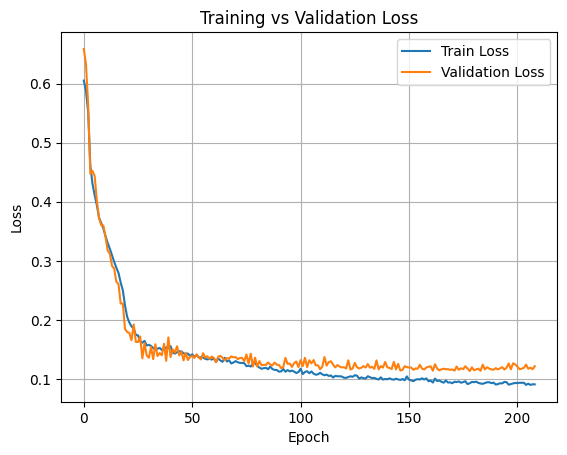

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.show()

In [20]:
reconstructed = autoencoder.predict(X_seq)
reconstruction_error = np.mean((X_seq - reconstructed)**2, axis=(1, 2))

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step


In [21]:
threshold = np.percentile(reconstruction_error, 95)
warnings = []
for i in range(len(reconstruction_error)):
    orig_seq = subset.iloc[i:i+sequence_len]
    if reconstruction_error[i] > threshold and \
       ((orig_seq["W(ms)"].max() > 2.5) or \
        (orig_seq["SNR(dB)"].max() > 10) or \
        (orig_seq["Cn2(dB)"].diff().abs().max() > 5)):
        warnings.append(True)
    else:
        warnings.append(False)

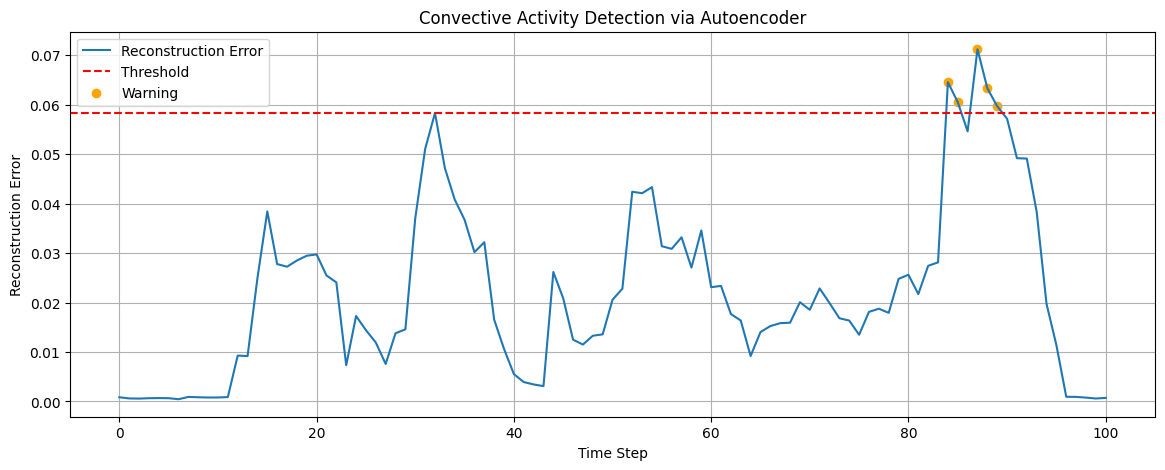

In [22]:
plt.figure(figsize=(14, 5))
plt.plot(reconstruction_error, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(np.arange(len(warnings))[warnings], reconstruction_error[warnings], color='orange', label='Warning')
plt.legend()
plt.title('Convective Activity Detection via Autoencoder')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

In [23]:
warning_times = subset.iloc[:len(warnings)][["Timestamp","Day","Month","Year"]].values[np.array(warnings)]
print("\n Warning Times Detected:")
print(warning_times)


 Warning Times Detected:
[[170954      1      5   2023]
 [171009      6      5   2023]
 [171522      1      5   2023]
 [171537      6      5   2023]
 [171942      5      1   2023]]
